In [4]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 39.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [2]:
import keras
keras.__version__

'2.12.0'

In [5]:
#changing to current working directory
import os

project_folder = "drive//MyDrive//faceExpressionRecognition"
os.chdir(project_folder)

os.getcwd()

'/content/drive/MyDrive/faceExpressionRecognition'

In [ ]:

'''
import string

import cv2
import numpy as np
import operator
import fnmatch

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Flatten,Reshape, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.regularizers import l2
from random import shuffle
'''

**<u>Importing Libraries<u>**

In [14]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Lambda
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional,GRU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D,Dropout

from keras.regularizers import l2,l1
import numpy as np

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix,f1_score

import tensorflow as tf
from keras.callbacks import ModelCheckpoint,EarlyStopping
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**<u>Loading image data and scaling</u>**

In [7]:
valid_img = np.load('dataFiles//valid_img.npy')
valid_label = np.load('dataFiles//valid_label.npy')

training_img = np.load('dataFiles//training_img.npy')
training_label = np.load('dataFiles//training_label.npy')

training_img = np.array(training_img).reshape(-1,64,64,1)
training_label=np.array(training_label)

valid_img = np.array(valid_img).reshape(-1,64,64,1)
valid_label=np.array(valid_label)

training_img = training_img/255.0
valid_img = valid_img/255.0

**<u>User defined functions helps to unnderstand the model performance</u>**

In [8]:
def total_no_misclassified(cm):
    total_sum_confusion_matrix = sum(cm)
    for i in range(len(cm)):
        total_sum_confusion_matrix[i] = total_sum_confusion_matrix[i]-(cm[i][i])
    return sum(total_sum_confusion_matrix)


def plot_accuracy_loss(history):
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


def plot_cofusion_matrix_two_models(cm1,cm2,
                             title1,title2):
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(valid_label),
                yticklabels=np.unique(valid_label))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title1)

    plt.subplot(1,2,2)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(valid_label),
                yticklabels=np.unique(valid_label))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title2)

    plt.show()

**<u>CRNN Model architecture</u>**

In [9]:
def model_architecture_params_tuning(regularization = l1,
                                     dropout_rate = 0.2,
                                     optimiser = 'adam',
                                     gru_hidden_layer = 64,
                                     rate_learninig = 0.001):
    # Initialize the sequential model
    model = Sequential()
    model.add(Conv2D(64, kernel_size=2, activation='relu',
                    kernel_regularizer=regularization(0.001),
                     input_shape=(64, 64, 1)))
    model.add(Conv2D(64, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, kernel_size=2, activation='relu',padding='same',
                    kernel_regularizer=regularization(0.001)))
    model.add(Conv2D(128, kernel_size=2, activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2,padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(256, kernel_size=2, activation='relu',padding='same'))
    model.add(Conv2D(256, kernel_size=2, activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(512, kernel_size=2, activation='relu',padding='same',
                    kernel_regularizer=regularization(0.001)))
    model.add(MaxPool2D(pool_size=3))

    # Reshape for the LSTM layer
    model.add(Lambda(lambda x: K.squeeze(x, 1)))

    # Add Bidirectional LSTM layer
    # model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(GRU(gru_hidden_layer, return_sequences=True))
    #model.add(Bidirectional(LSTM(128, return_sequences=True)))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Print the model summary
    #model.summary()
    return model


In [10]:
model = model_architecture_params_tuning()
history = model.fit(training_img, training_label,
										validation_data=(valid_img, valid_label),
										epochs=20,batch_size = 64)

Epoch 1/20
403/403 [==============================] - 57s 83ms/step - loss: 3.0182 - accuracy: 0.2599 - val_loss: 2.1789 - val_accuracy: 0.2516
Epoch 2/20
403/403 [==============================] - 31s 76ms/step - loss: 2.0186 - accuracy: 0.2818 - val_loss: 2.0535 - val_accuracy: 0.2677
Epoch 3/20
403/403 [==============================] - 30s 75ms/step - loss: 1.9312 - accuracy: 0.3039 - val_loss: 1.8843 - val_accuracy: 0.3062
Epoch 4/20
403/403 [==============================] - 30s 74ms/step - loss: 1.8489 - accuracy: 0.3537 - val_loss: 1.8962 - val_accuracy: 0.3345
Epoch 5/20
403/403 [==============================] - 30s 74ms/step - loss: 1.7453 - accuracy: 0.4260 - val_loss: 1.7465 - val_accuracy: 0.4115
Epoch 6/20
403/403 [==============================] - 30s 75ms/step - loss: 1.6403 - accuracy: 0.4647 - val_loss: 1.7822 - val_accuracy: 0.3894
Epoch 7/20
403/403 [==============================] - 31s 76ms/step - loss: 1.5766 - accuracy: 0.4834 - val_loss: 1.6173 - val_accuracy:

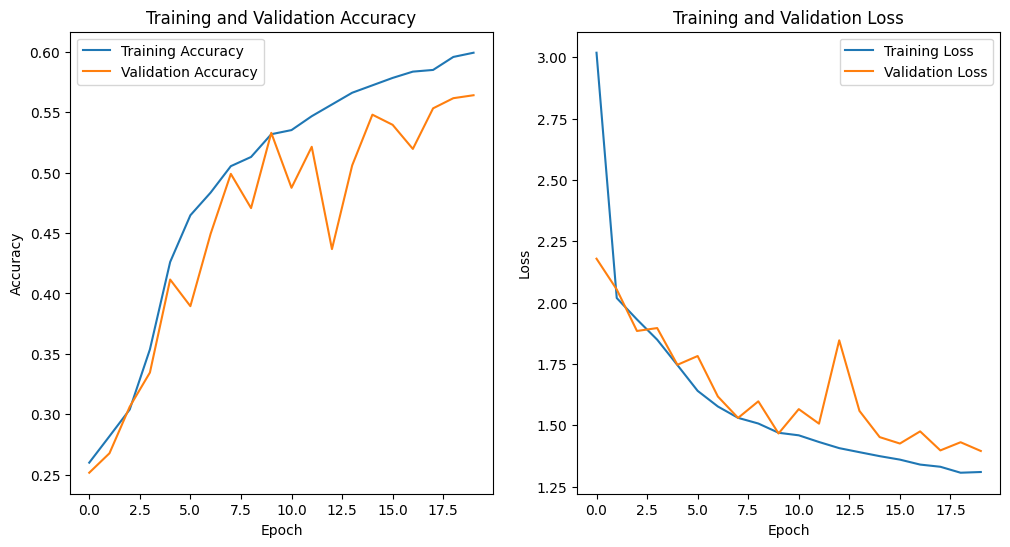

In [11]:
plot_accuracy_loss(history)

In [13]:
score = model.evaluate(valid_img, valid_label, verbose = 0)

# Assuming y_true and y_pred are your true and predicted labels
y_pred1 = model.predict(valid_img)
y_pred_classes1 = [[np.argmax(pred, axis=1)[0]] for pred in y_pred1]

cm1 = confusion_matrix(valid_label, y_pred_classes1)

# Calculate F1 score for each class
f1 = f1_score(valid_label, y_pred_classes1, average='weighted')

print("F1 Score: {:.4f}".format(f1))
print('Test score: {:.2f}%'.format(score[1] * 100))
print("CNN Error: {:.2f}%".format((100 - score[1] * 100)))

print("Total no misclassified classes for model architecture1 is {}".format(
    total_no_misclassified(cm1)))

90/90 [==============================] - 1s 8ms/step
F1 Score: 0.5368
Test score: 56.40%
CNN Error: 43.60%
Total no misclassified classes for model architecture1 is 1246


**<u>K-FOLD CROSS VALIDATION</u>**

In [15]:
# Perform cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kfold.split(training_img, training_label):
    X_train, X_test = training_img[train_index], training_img[test_index]
    y_train, y_test = training_label[train_index], training_label[test_index]

    model = model_architecture_params_tuning()
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(accuracy)

print(f"Accuracy: {np.mean(accuracies):.2f} (+/- {np.std(accuracies):.2f})")

Accuracy: 0.55 (+/- 0.01)


**<u>Hyper parameter Tunning</u>**

In [17]:
%%time
# Create a KerasClassifier for use in scikit-learn
model = KerasClassifier(build_fn=model_architecture_params_tuning, verbose=2)

# Define the hyperparameters to search over
param_dist = {
    'rate_learninig': [0.001, 0.01, 0.1],
    'regularization': [l1,l2],
    'dropout_rate': [0.2, 0.3, 0.4],
    'optimiser': ['adam', 'sgd','rmsprop'],
    'gru_hidden_layer': [64,128,196,256]
}

# Perform RandomizedSearchCV
n_iter_search = 10

random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(training_img, training_label,
                  validation_data=(valid_img, valid_label))

print("Best parameters found: ", random_search.best_params_)


<timed exec>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


644/644 - 35s - loss: 1.9535 - accuracy: 0.2393 - val_loss: 1.8422 - val_accuracy: 0.2390 - 35s/epoch - 55ms/step
161/161 - 2s - loss: 1.8426 - accuracy: 0.2308 - 2s/epoch - 10ms/step
644/644 - 34s - loss: 1.9680 - accuracy: 0.2363 - val_loss: 1.8269 - val_accuracy: 0.2516 - 34s/epoch - 52ms/step
161/161 - 2s - loss: 1.8349 - accuracy: 0.2572 - 2s/epoch - 11ms/step
644/644 - 34s - loss: 1.9590 - accuracy: 0.2419 - val_loss: 1.8474 - val_accuracy: 0.1994 - 34s/epoch - 53ms/step
161/161 - 1s - loss: 1.8487 - accuracy: 0.1928 - 1s/epoch - 9ms/step
644/644 - 34s - loss: 1.9742 - accuracy: 0.2432 - val_loss: 1.8441 - val_accuracy: 0.2516 - 34s/epoch - 53ms/step
161/161 - 1s - loss: 1.8395 - accuracy: 0.2559 - 1s/epoch - 9ms/step
644/644 - 34s - loss: 1.9586 - accuracy: 0.2419 - val_loss: 1.8519 - val_accuracy: 0.2516 - 34s/epoch - 53ms/step
161/161 - 1s - loss: 1.8501 - accuracy: 0.2449 - 1s/epoch - 9ms/step
644/644 - 35s - loss: 1.9742 - accuracy: 0.2373 - val_loss: 1.8542 - val_accuracy: 

In [19]:
model = model_architecture_params_tuning(regularization=l1,
                                         rate_learninig=0.001,
                                         optimiser='adam',
                                         gru_hidden_layer=64,
                                         dropout_rate=0.2)
model.fit(training_img, training_label,
          validation_data=(valid_img, valid_label),
          epochs=20,
          batch_size = 64,
          verbose=2)

Epoch 1/20
403/403 - 37s - loss: 3.0238 - accuracy: 0.2539 - val_loss: 2.1823 - val_accuracy: 0.2593 - 37s/epoch - 93ms/step
Epoch 2/20
403/403 - 29s - loss: 1.9832 - accuracy: 0.3261 - val_loss: 2.1529 - val_accuracy: 0.2712 - 29s/epoch - 71ms/step
Epoch 3/20
403/403 - 28s - loss: 1.8413 - accuracy: 0.4025 - val_loss: 2.0549 - val_accuracy: 0.2901 - 28s/epoch - 71ms/step
Epoch 4/20
403/403 - 29s - loss: 1.6972 - accuracy: 0.4465 - val_loss: 1.9229 - val_accuracy: 0.3135 - 29s/epoch - 71ms/step
Epoch 5/20
403/403 - 28s - loss: 1.6396 - accuracy: 0.4736 - val_loss: 1.6176 - val_accuracy: 0.4727 - 28s/epoch - 70ms/step
Epoch 6/20
403/403 - 28s - loss: 1.5778 - accuracy: 0.4929 - val_loss: 1.7494 - val_accuracy: 0.4314 - 28s/epoch - 70ms/step
Epoch 7/20
403/403 - 28s - loss: 1.5333 - accuracy: 0.5111 - val_loss: 1.4655 - val_accuracy: 0.5206 - 28s/epoch - 70ms/step
Epoch 8/20
403/403 - 29s - loss: 1.4933 - accuracy: 0.5217 - val_loss: 1.6983 - val_accuracy: 0.4087 - 29s/epoch - 72ms/step


In [20]:
score = model.evaluate(valid_img, valid_label, verbose = 0)

# Assuming y_true and y_pred are your true and predicted labels
y_pred2 = model.predict(valid_img)
y_pred_classes2 = [[np.argmax(pred, axis=1)[0]] for pred in y_pred2]

cm2 = confusion_matrix(valid_label, y_pred_classes2)

# Calculate F1 score for each class
f1 = f1_score(valid_label, y_pred_classes2, average='weighted')

print("F1 Score: {:.4f}".format(f1))
print('Test score: {:.2f}%'.format(score[1] * 100))
print("CNN Error: {:.2f}%".format((100 - score[1] * 100)))

90/90 [==============================] - 2s 10ms/step
F1 Score: 0.5383
Test score: 55.77%
CNN Error: 44.23%


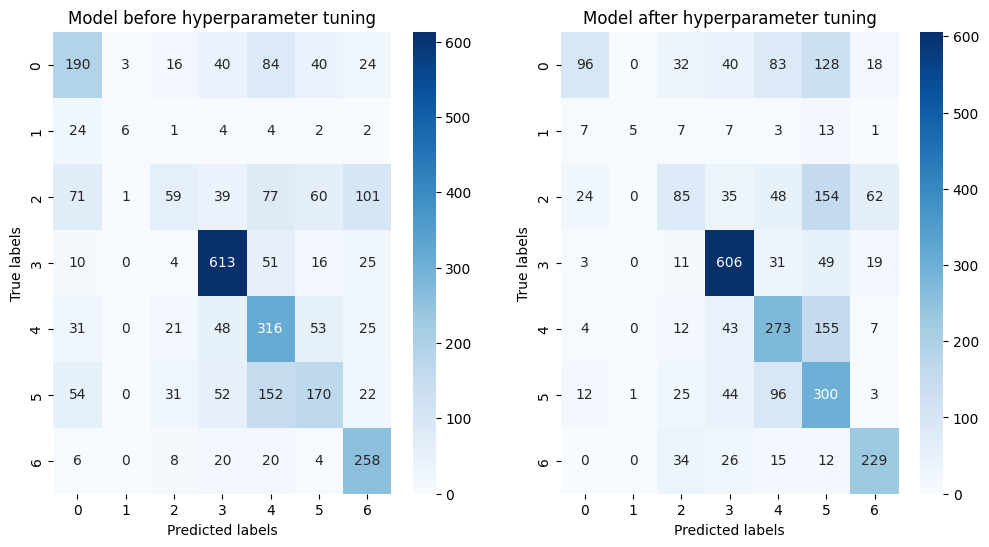

Total no misclassified classes for model architecture1 is 1246
Total no misclassified classes for model architecture1 is 1264


In [21]:
title1 = "Model before hyperparameter tuning"
title2 = 'Model after hyperparameter tuning'
plot_cofusion_matrix_two_models(cm1,cm2,
                             title1,title2)

print("Total no misclassified classes for model architecture1 is {}".format(
    total_no_misclassified(cm1)))
print("Total no misclassified classes for model architecture1 is {}".format(
    total_no_misclassified(cm2)))

In [22]:
# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)
model_checkpoint = ModelCheckpoint('dataFiles//best_crnn_model.h5',
                                   monitor='val_loss', save_best_only=True)

model = model_architecture_params_tuning()
model.fit(training_img, training_label,
          validation_data=(valid_img, valid_label),
          callbacks=[early_stopping, model_checkpoint],
          epochs=40,
          batch_size = 64,
          verbose=2)

Epoch 1/40
403/403 - 41s - loss: 3.0442 - accuracy: 0.2444 - val_loss: 2.0624 - val_accuracy: 0.2516 - 41s/epoch - 101ms/step
Epoch 2/40
403/403 - 29s - loss: 2.0267 - accuracy: 0.2724 - val_loss: 2.0279 - val_accuracy: 0.2775 - 29s/epoch - 73ms/step
Epoch 3/40
403/403 - 28s - loss: 1.9616 - accuracy: 0.3048 - val_loss: 2.0456 - val_accuracy: 0.2568 - 28s/epoch - 70ms/step
Epoch 4/40
403/403 - 29s - loss: 1.8866 - accuracy: 0.3624 - val_loss: 1.9407 - val_accuracy: 0.3156 - 29s/epoch - 73ms/step
Epoch 5/40
403/403 - 30s - loss: 1.7417 - accuracy: 0.4353 - val_loss: 1.7902 - val_accuracy: 0.3828 - 30s/epoch - 74ms/step
Epoch 6/40
403/403 - 29s - loss: 1.6268 - accuracy: 0.4693 - val_loss: 1.8307 - val_accuracy: 0.3537 - 29s/epoch - 71ms/step
Epoch 7/40
403/403 - 29s - loss: 1.5573 - accuracy: 0.4877 - val_loss: 1.5804 - val_accuracy: 0.4752 - 29s/epoch - 73ms/step
Epoch 8/40
403/403 - 28s - loss: 1.5119 - accuracy: 0.5062 - val_loss: 1.6012 - val_accuracy: 0.4612 - 28s/epoch - 70ms/step

**<u>Data Augumentation</u>**

In [23]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.6, 0.8],
    horizontal_flip=True,
)

In [24]:
datagen.fit(training_img)
# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)
model_checkpoint = ModelCheckpoint('dataFiles//best_crnn_data_model.h5',
                                   monitor='val_loss', save_best_only=True)

model = model_architecture_params_tuning()
model.fit(datagen.flow(training_img, training_label, batch_size=64),
          steps_per_epoch=len(training_img) / 64,
          validation_data=(valid_img, valid_label),
          callbacks=[early_stopping, model_checkpoint],
          epochs=40,
          verbose=2)

Epoch 1/40
402/402 - 56s - loss: 2.5623 - accuracy: 0.2504 - val_loss: 1.9428 - val_accuracy: 0.2516 - 56s/epoch - 140ms/step
Epoch 2/40
402/402 - 38s - loss: 1.9256 - accuracy: 0.2514 - val_loss: 1.9125 - val_accuracy: 0.2516 - 38s/epoch - 95ms/step
Epoch 3/40
402/402 - 35s - loss: 1.9045 - accuracy: 0.2514 - val_loss: 1.8965 - val_accuracy: 0.2516 - 35s/epoch - 88ms/step
Epoch 4/40
402/402 - 36s - loss: 1.8938 - accuracy: 0.2514 - val_loss: 1.8893 - val_accuracy: 0.2516 - 36s/epoch - 89ms/step
Epoch 5/40
402/402 - 36s - loss: 1.8878 - accuracy: 0.2514 - val_loss: 1.8858 - val_accuracy: 0.2516 - 36s/epoch - 90ms/step
Epoch 6/40
402/402 - 36s - loss: 1.8842 - accuracy: 0.2514 - val_loss: 1.8832 - val_accuracy: 0.2516 - 36s/epoch - 89ms/step
Epoch 7/40
402/402 - 35s - loss: 1.8820 - accuracy: 0.2514 - val_loss: 1.8806 - val_accuracy: 0.2516 - 35s/epoch - 87ms/step
Epoch 8/40
402/402 - 33s - loss: 1.8807 - accuracy: 0.2514 - val_loss: 1.8801 - val_accuracy: 0.2516 - 33s/epoch - 83ms/step

In [25]:
score = model.evaluate(valid_img, valid_label, verbose = 0)

# Assuming y_true and y_pred are your true and predicted labels
y_pred3 = model.predict(valid_img)
y_pred_classes3 = [[np.argmax(pred, axis=1)[0]] for pred in y_pred3]

cm3 = confusion_matrix(valid_label, y_pred_classes3)

# Calculate F1 score for each class
f1 = f1_score(valid_label, y_pred_classes3, average='weighted')

print("F1 Score: {:.4f}".format(f1))
print('Test score: {:.2f}%'.format(score[1] * 100))
print("CNN Error: {:.2f}%".format((100 - score[1] * 100)))

print("Total no misclassified classes for model architecture1 is {}".format(
    total_no_misclassified(cm3)))

90/90 [==============================] - 1s 8ms/step
F1 Score: 0.1011
Test score: 25.16%
CNN Error: 74.84%
Total no misclassified classes for model architecture1 is 2139
